In [1]:
import sys
sys.path.append("../src")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from exact_solution import solve_master_equation, one_excited_emitter_state

In [2]:
# load data from superstaq compilation without mirror swaps
run1 = np.load('../data/QSCOUT/superstaq 2000 shots/Experiment Probabilities_1.npy', allow_pickle=True) 
run2 = np.load('../data/QSCOUT/superstaq 2000 shots/Experiment Probabilities_2.npy', allow_pickle=True)
run3 = np.load('../data/QSCOUT/superstaq 2000 shots/Experiment Probabilities_3.npy', allow_pickle=True)

lines = []
for timestep in zip(run1, run2, run3):
    timestep_data = {key: _ for key in timestep[0].keys()}
    for key, _ in timestep_data.items():
        timestep_data[key] = np.sum([timestep[0][key], timestep[1][key], timestep[2][key]])
    lines.append(timestep_data)
    
superstaq_results = pd.DataFrame(lines)

# renormalization and averaging
superstaq_results[['1000', '0100', '0010', '0001']] = superstaq_results[['1000', '0100', '0010', '0001']].divide(superstaq_results[['1000', '0100', '0010', '0001']].sum(axis=1), axis=0)
superstaq_results['avg_0100_0010'] = superstaq_results[['0100', '0010']].mean(axis=1)

In [3]:
# mirror swaps, 3 runs of 2000 shots
run1 = np.load('../data/QSCOUT/mirror_swaps/Experiment Probabilities.npy', allow_pickle=True) 
run2 = np.load('../data/QSCOUT/mirror_swaps/Experiment Probabilities (1).npy', allow_pickle=True)
run3 = np.load('../data/QSCOUT/mirror_swaps/Experiment Probabilities (2).npy', allow_pickle=True)

lines = []
for timestep in zip(run1, run2, run3):
    timestep_data = {key: _ for key in timestep[0].keys()}
    for key, _ in timestep_data.items():
        timestep_data[key] = (np.mean([timestep[0][key], timestep[1][key], timestep[2][key]]))
    lines.append(timestep_data)
    
mirror_swaps_results = pd.DataFrame(lines)
orig = mirror_swaps_results.copy()

# Do the virtual relabeling of the qubits which is part of the mirror swap
mirror_swaps_results.loc[10:, ['1000', '0001']] = mirror_swaps_results.loc[10:, ['0001', '1000']].values

# renormalization on mirror swaps data
mirror_swaps_results[['1000', '0100', '0010', '0001']] = mirror_swaps_results[['1000', '0100', '0010', '0001']].divide(mirror_swaps_results[['1000', '0100', '0010', '0001']].sum(axis=1), axis=0)
mirror_swaps_results['avg_0100_0010'] = mirror_swaps_results[['0100', '0010']].mean(axis=1)

In [4]:
N = 3
g = 2
kappa = 5
times = np.linspace(0, 3, 51)

In [5]:
initial_state = one_excited_emitter_state(N, 1)
qutip_results = solve_master_equation(N, g, kappa, initial_state, times)

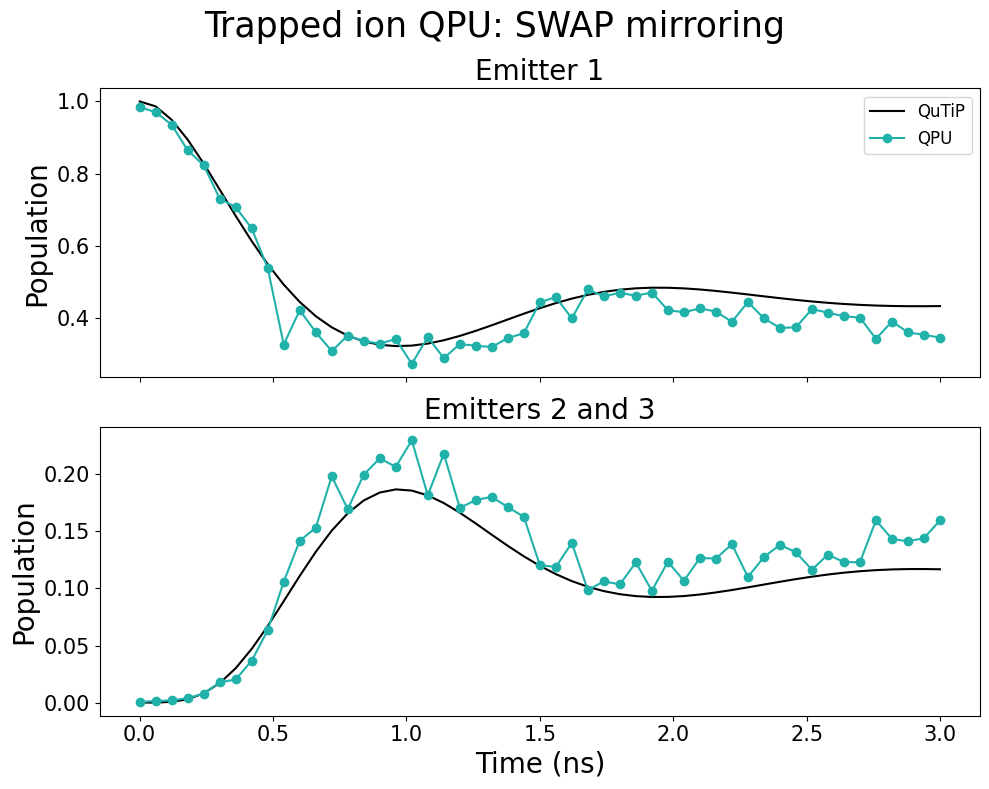

In [6]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

axes[0].set_title("Emitter 1", fontsize=20)
axes[0].plot(qutip_results.index, qutip_results["Emitter 1"], label="QuTiP", color='black')
# axes[0].plot(times, superstaq_results["1000"], marker='o', label="QPU (no SWAP mirroring)")
axes[0].plot(times, mirror_swaps_results["1000"], marker='o', label="QPU", color='#20b2aa')
axes[0].set_ylabel("Population", fontsize=20)
axes[0].legend(fontsize=12)
axes[0].tick_params(axis='y', labelsize=15)
axes[0].set_xticklabels([])

axes[1].set_title("Emitters 2 and 3", fontsize=20)
axes[1].plot(qutip_results.index, qutip_results["Emitter 2"], label="QuTiP", color='black')
# axes[1].plot(times, superstaq_results["avg_0100_0010"], marker='o', label="QPU (no SWAP mirroring)")
axes[1].plot(times, mirror_swaps_results["avg_0100_0010"], marker='o', label="QPU", color='#20b2aa')

axes[1].set_ylabel("Population", fontsize=20)
axes[1].tick_params(axis='y', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)

axes[1].set_xlabel("Time (ns)", fontsize=20)

fig.suptitle("Trapped ion QPU: SWAP mirroring", fontsize=25)
plt.tight_layout()

In [7]:
fig.savefig("../figures/QSCOUT_mirror_swaps.eps")

In [8]:
from errorbars import calculate_mae_uncertainty, write_results_to_file

exp = mirror_swaps_results["1000"]
thy = qutip_results["Emitter 1"]
results = calculate_mae_uncertainty(exp, thy)
write_results_to_file(results, processor="QSCOUT", emitter="Emitter 1", condition="Mirror SWAPs")

#######

exp = mirror_swaps_results["avg_0100_0010"]
thy = qutip_results["Emitter 2"]
results = calculate_mae_uncertainty(exp, thy)
write_results_to_file(results, processor="QSCOUT", emitter="Emitter 2", condition="Mirror SWAPs")